
# Phase synchronization analysis with xphasesync

This notebook demonstrates how to calculate phase synchronization using the xphasesync package, Supplementary Fig. 12 in Stuecker et al. 2025. Please cite our paper if you use our code.

Stuecker, M. F., Zhao, S., Timmermann, A., Ghosh, R., Semmler, T., Lee, S.-S., et al. (2025). Global climate mode resonance due to rapidly intensifying El Niño–Southern Oscillation. **Nature Communications**. in revision. 


In [1]:
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import os
import glob

import numpy  as np
import xarray as xr
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# pip install -e . 
from xphasesync import xphasesync


## White noise 
def whitenoise(amp_w=1., N=1200, ncopy=1, seed=None):
    '''
        return white noise
    '''
    if seed is not None:
        np.random.seed(seed)
    w_ds = np.random.normal(0, amp_w, size=(N, ncopy))
    out_noise = xr.DataArray(w_ds, dims={'time', 'member'},
                             coords={'time': np.arange(0, N, step=1, dtype=float),
                                     'member': np.arange(0, ncopy, step=1, dtype=int)})
    return out_noise


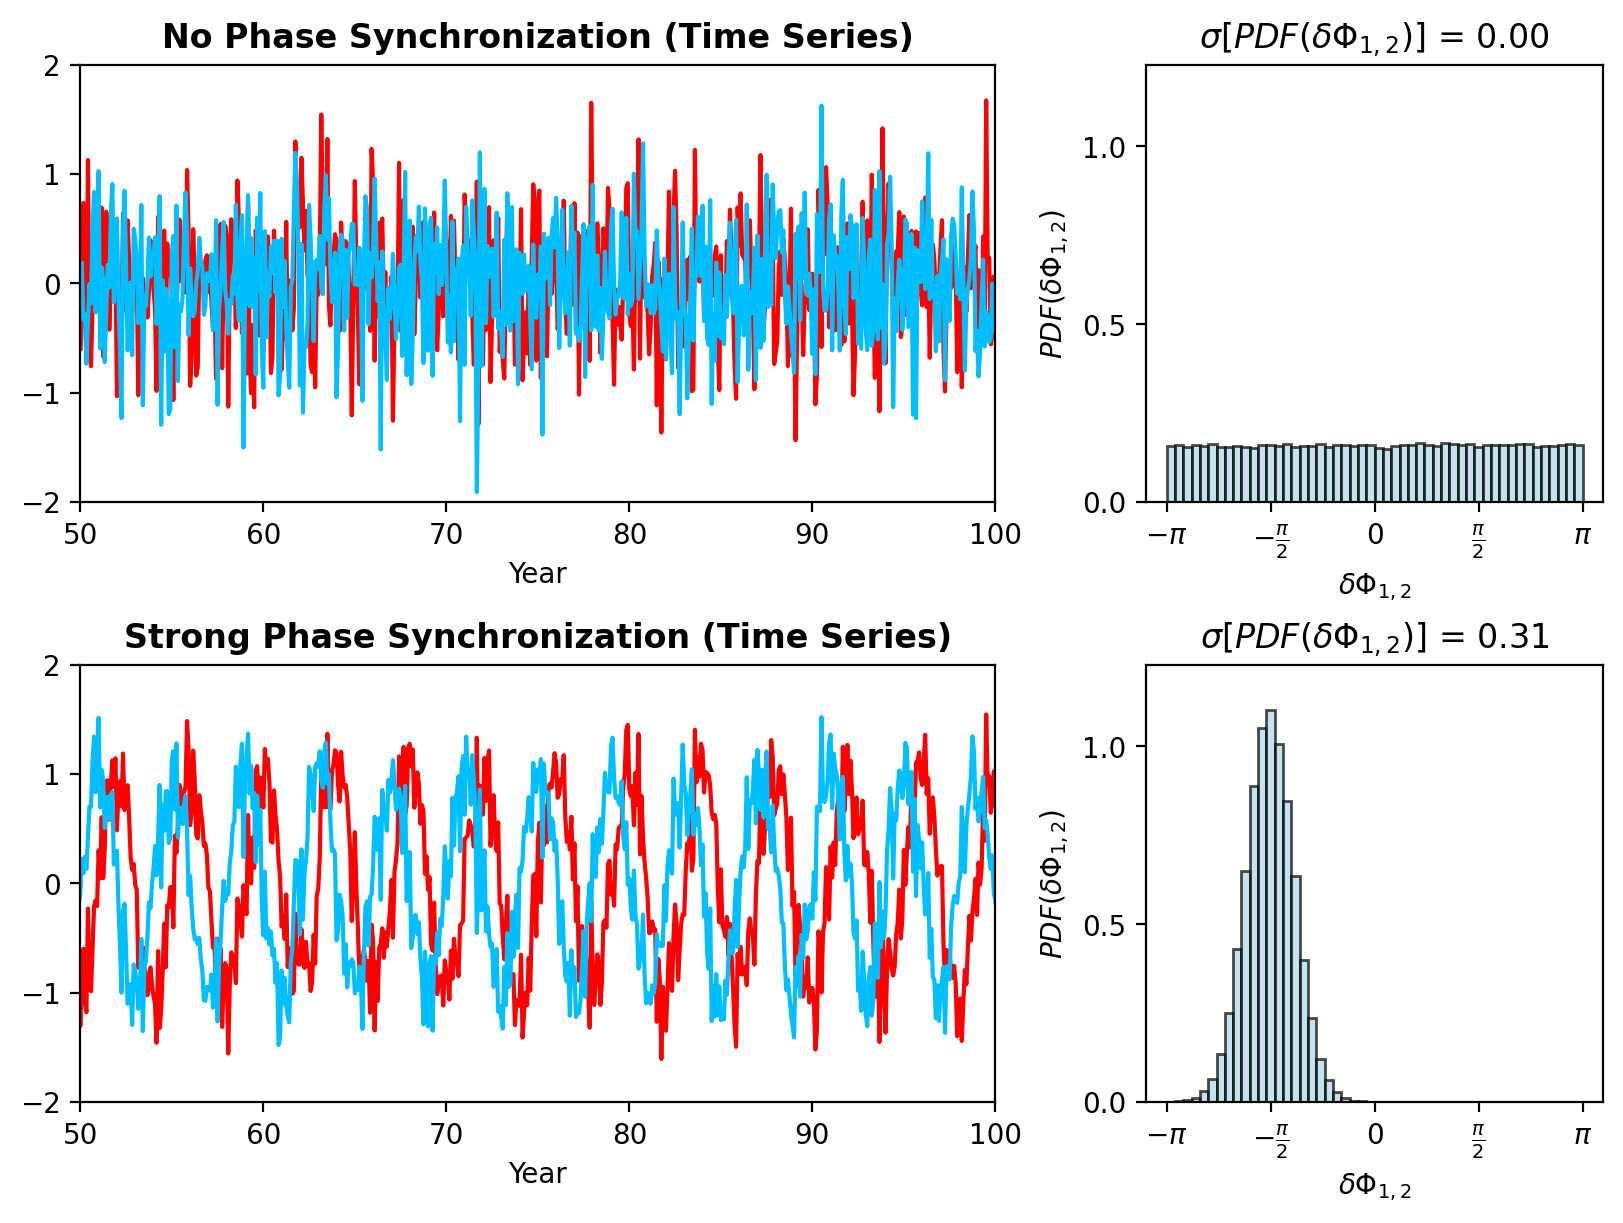

In [2]:
seed = 1000
wnoise = whitenoise(amp_w=0.5, ncopy=2, N=120000, seed=seed) #.squeeze(dim='member', drop=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 6), width_ratios=[2, 1],  layout='compressed')

## white noises
w1 = wnoise.isel(member=0)
w2 = wnoise.isel(member=1)
sync_w = xphasesync(w1, w2, dim='time', bins=50)['Hist']

ax = axes.flat[0]
ax.plot(w1.time/12, w1, c='red', label='X1')
ax.plot(w2.time/12, w2, c='deepskyblue', label='X2')
ax.set_title("No Phase Synchronization (Time Series)", fontweight='bold')

ax = axes.flat[1]
ax.bar(sync_w.bins, sync_w, width=sync_w.bins[1]-sync_w.bins[0],
       color='lightblue', edgecolor='black', alpha=0.7)
ax.set_title(f"$\\sigma[PDF(\\delta \\Phi_{{1,2}})]$ = {sync_w.std('bins').values:.2f}")

##
Period = 48
DeltaPhi = -12
x1 = np.cos(2*np.pi/Period * wnoise.time) + wnoise.isel(member=0).values * 0.5
x2 = np.cos(2*np.pi/Period * (wnoise.time - DeltaPhi) ) + wnoise.isel(member=1).values * 0.5

sync_x = xphasesync(x1, x2, dim='time', bins=50)['Hist']

ax = axes.flat[2]
ax.plot(x1.time/12, x1, c='red', label='Y1')
ax.plot(x2.time/12, x2, c='deepskyblue', label='Y2')
# ax.set_title("Strong phase sync: time series", fontweight='bold')
ax.set_title("Strong Phase Synchronization (Time Series)", fontweight='bold')

ax = axes.flat[3]
ax.bar(sync_x.bins, sync_x, width=sync_x.bins[1]-sync_x.bins[0],
       color='lightblue', edgecolor='black', alpha=0.7)
ax.set_title(f"$\\sigma[PDF(\\delta \\Phi_{{1,2}})]$ = {sync_x.std('bins').values:.2f}")

for ax in axes[:, 0].flat:
    ax.set_xlabel(f"Year")
    ax.set_ylabel('')
    ax.set_ylim([-2, 2])
    ax.set_xlim([50, 100])

for ax in axes[:, 1].flat:
    ax.set_xlabel(f"$\\delta \\Phi_{{1,2}}$")
    ax.set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
    ax.set_xticklabels(["$-\\pi$", "$-\\frac{\\pi}{2}$", "0", "$\\frac{\\pi}{2}$", "$\\pi$"])
    ax.set_ylabel('$PDF(\\delta \\Phi_{{1,2}})$')
    ax.set_yticks(np.arange(0, 1.6, step=0.5))
    ax.set_ylim([0, 1.23])
